# Univariate linear regression

Now that we have our linear expression 

$$
Y = \beta_0 + \sum_{i = 1} \beta_i X_i
$$

we can attempt to find the values for each $\beta$.

In [1]:
import pandas as pd


CSV_PATH = "https://gitlab.com/oasci/courses/pitt/biosc1540-2024s/-/raw/main/biosc1540/files/csv/advertising-data.csv"

df_adv = pd.read_csv(CSV_PATH)
print(df_adv)

         TV  Billboards  Google_Ads  Social_Media  Influencer_Marketing  \
0    281.42      538.80      123.94        349.30                242.77   
1    702.97      296.53      558.13        180.55                781.06   
2    313.14      295.94      642.96        505.71                438.91   
3    898.52       61.27      548.73        240.93                278.96   
4    766.52      550.72      651.91        666.33                396.33   
..      ...         ...         ...           ...                   ...   
395  873.32      234.67      563.21        401.88                789.44   
396  421.88      449.22      564.77        334.88                689.77   
397  599.22      789.88      831.32        450.88                398.44   
398  784.33      500.67      958.88        635.22                786.44   
399  290.67      321.88      640.56        765.22                409.77   

     Affiliate_Marketing  Product_Sold  
0                 910.10        7164.0  
1                

Instead of trying to find all these at once we will just start with `Social_Media`.

The code snippet provided utilizes the NumPy library to convert relevant columns from a DataFrame (`df_adv`) into NumPy arrays.
Specifically, we extract the social media advertising costs (`cost_social_media`) and the corresponding product sales (`product_sold`).
The subsequent print statements offer a sneak peek into the shape and initial entries of the `product_sold` array, providing essential insights for further analysis and interpretation

In [2]:
import numpy as np

cost_social_media = df_adv["Social_Media"].to_numpy()
product_sold = df_adv["Product_Sold"].to_numpy()

print(product_sold.shape)
print(product_sold[:10])

(400,)
[7164. 5055. 6154. 5480. 9669. 7627. 5177. 3726. 9801. 8652.]


## SciPy

We now shift our focus to the optimization capabilities of SciPy.
In this section, we'll employ SciPy's optimization functions to find the optimal parameters for a linear model that best fits our advertising data. 

### Defining our model

The `linear_model` function, defined in the upcoming code block, represents a generic linear expression with parameters `beta_0` and `beta_1`.
Utilizing SciPy's optimization routines, we aim to fine-tune these parameters to minimize the difference between the predicted and actual product sales.
This approach enables us to uncover the optimal linear relationship between social media advertising costs and product sales, enhancing the accuracy of our predictive model.

In [3]:
def linear_model(betas, x):
    """Generic linear expression"""
    beta_0, beta_1 = betas
    y = beta_0 + beta_1 * x
    return y

The `linear_model` function takes two parameters: `betas` and `x`.

-   `betas`: This parameter is expected to be a sequence (e.g., list or array) containing the coefficients of the linear model.
    In the context of a simple linear regression model, `betas` would typically have two elements, representing the intercept (`beta_0`) and the slope (`beta_1`).

- `x`: This parameter represents the input values for which the function will compute the corresponding output.

Inside the function:

1. The coefficients are unpacked from `betas` into individual variables (`beta_0` and `beta_1`).
2. The linear expression $y = \beta_0 + \beta_1 x_1$ is computed.
    This equation represents a straight line where `beta_0` is the intercept, `beta_1` is the slope, and `x` is the input variable.
3. The computed `y` is returned as the output of the function.

By defining the linear model in this way, you create a flexible and reusable function that can handle various linear models with different numbers of coefficients. This abstraction is particularly useful when optimizing or fitting the model to data, as it allows you to use the same function with different sets of parameters, making it adaptable to a wide range of scenarios in regression analysis.


**Why is it `linear_model(betas, x)` and not `linear_model(beta_0, beta_1, x)`?**

> The choice of `(betas, x)` in the function signature `linear_model(betas, x)` is a deliberate design decision for enhanced flexibility and generality.
>
> By using a single parameter `betas` instead of specifying `beta_0` and `beta_1` individually, the function becomes more versatile and can accommodate a variable number of parameters.
> The `betas` parameter is expected to be a sequence (e.g., a list or array) containing all the coefficients of the linear model. In the case of a simple linear regression model (as in your example), `betas` would represent `beta_0` and `beta_1`.
> However, this design allows for the extension of the model to include additional coefficients without modifying the function signature.
> Whether dealing with a simple or more complex linear model, this approach enhances the reusability of the `linear_model` function, aligning with the principles of clean and extensible code.
>
> Another big reason is that this is how the function to minimize code requires our model to be.

### Defining our loss function

Loss functions play a crucial role in regression tasks, and their primary purpose is to quantify the difference between the predicted values of a model and the actual observed values.
In the context of regression, a loss function measures how well the model's predictions align with the true outcomes.

![](https://images.squarespace-cdn.com/content/v1/5acbdd3a25bf024c12f4c8b4/1600368657769-5BJU5FK86VZ6UXZGRC1M/Mean+Squared+Error.png)

Here are key points regarding the importance of loss functions in regression.

1. **Quantifying Error:** Loss functions provide a numerical measure of the error or deviation between the predicted values and the actual values.
2. **Optimization:** During the training of a regression model, the goal is to find the set of parameters (coefficients) that minimizes the chosen loss function. This process is known as optimization.
    By minimizing the loss, the model learns to make predictions that are as close as possible to the actual outcomes.
3. **Model Evaluation:** Loss functions are also used for evaluating the performance of a trained model on new, unseen data.
    A lower loss indicates better model performance, as it implies that the model's predictions are closer to the true values.
4. **Comparison of Models:** Different regression models or configurations can be compared based on their respective loss values.
    Models with lower loss values are generally considered more effective in capturing the underlying patterns in the data.

In our case, we will use the mean squared error (MSE) as it is a commonly used and robust for regression.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

-   $n$ is the number of observations or data points.
-   $y_i$ represents the actual or observed value for the $i$-th data point.
-   $\hat{y}_i$ represents the predicted value for the $i$-th data point.
-   The summation $\sum_{i=1}^{n}$ is taken over all data points.
-   The squared difference $(y_i - \hat{y}_i)^2$ is calculated for each data point.
-   The overall MSE is the average of these squared differences.


In [4]:
def mse(betas, x_data, y_data):
    """Compute mean squared error of a linear model."""
    # Compute squared error
    y_pred = linear_model(betas, x_data)

    # Square and average errors
    errors = y_pred - y_data
    squared_errors = errors**2
    mse = squared_errors.mean()
    return mse

The `mse` function takes three parameters: `betas`, `x_data`, and `y_data`.

- `betas`: This parameter represents the coefficients of the linear model, similar to the `betas` parameter in the `linear_model` function.
- `x_data`: This parameter represents the input data.
- `y_data`: This parameter represents the actual output (ground truth) corresponding to the `x_data`.

Inside the function:

1. The coefficients (`beta_0` and `beta_1`) are unpacked from `betas`.
2. The linear model predictions (`y_pred`) are computed using the provided input data (`x_data`).
3. The squared errors between the predicted values and the actual values (`y_data`) are calculated.
4. The mean squared error (MSE) is computed by averaging the squared errors.
5. The computed MSE is returned as the output of the function.

### Optimization

The optimization process aims to find the values of parameters (coefficients) for the linear model that minimize the MSE.

-   **Objective Function**<br>
    The [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function requires an objective function to minimize.
    In this case, the objective is to minimize the mean squared error, so the `mse` function is used as the objective function.
-   **Optimization Algorithm**<br>
    The minimize function uses an optimization algorithm (specified by the method parameter) to iteratively adjust the parameters to minimize the objective function.
    The BFGS algorithm is a popular choice for unconstrained optimization.
-   **Parameter Update**<br>
    The optimization algorithm iteratively updates the parameters by considering the gradient of the objective function.
    It continues this process until convergence is achieved or a maximum number of iterations is reached.
-   **Convergence**<br>
    The optimization process stops when the algorithm converges to a set of parameters that approximately minimize the mean squared error.
-   **Result**<br>
    The result object contains information about the optimization, including the optimized parameters (`res.x`).
    These parameters represent the coefficients of the linear model that best fit the given data.

By using the mean squared error as the objective function, the optimization aims to find the parameters that result in the smallest average squared difference between the predicted and actual values, leading to an improved linear model for the given dataset.

Be sure to check the [`scipy.optimize.minimize` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for how it works!

#### Initial parameters

The use of initial parameters in optimization algorithms, such as the one employed by scipy.optimize.minimize, serves as a starting point for the algorithm to begin the iterative process of searching for the optimal values. The choice of initial parameters is crucial for the effectiveness and efficiency of the optimization. Here's why initial parameters are needed:

-   **Starting Point for Optimization**<br>
    Optimization algorithms typically work iteratively, adjusting the parameters in each iteration to minimize the objective function. The initial parameters provide the starting point for this iterative process. The algorithm explores the parameter space around these initial values to find the minimum of the objective function.
-   **Local Minimum vs. Global Minimum**<br>
    Depending on the shape of the objective function's surface (or landscape), there may be multiple local minima. The optimization algorithm seeks to find the global minimum, which represents the overall lowest value of the objective function. The choice of initial parameters can influence whether the algorithm converges to a local minimum or the global minimum.
-   **Convergence Behavior**<br>
    The behavior of the optimization algorithm during convergence can be sensitive to the initial parameters. The algorithm might converge to different solutions based on where it starts in the parameter space. Properly chosen initial parameters can help the algorithm converge more quickly and reliably to a good solution.
-   **Numerical Stability**<br>
    Some optimization algorithms involve numerical computations that may not be stable or well-behaved for certain parameter values. Choosing reasonable initial parameters can contribute to numerical stability during the optimization process.
-   **Domain Knowledge**<br>
    In some cases, domain knowledge or prior information about the problem can guide the selection of initial parameters. For example, if you have an educated guess about the likely range of values for certain parameters, using that information as initial values can expedite the optimization.
-   **Avoiding Convergence to Undesirable Solutions**<br>
    In situations where the objective function has multiple minima, setting initial parameters far from the desired solution may help avoid convergence to undesirable solutions. It can guide the optimization process toward regions of the parameter space that are more likely to lead to a good solution.

The initial guess for `beta_0` is set to the minimum value of the product_sold array.
This choice assumes that `beta_0` represents the intercept of the linear model.
Using the minimum value can be a reasonable starting point, especially if you expect the linear model to intersect the y-axis near the minimum observed product sold.

The initial guess for `beta_1` is calculated based on the ratio of the range of product_sold to the range of cost_social_media.
This ratio provides an estimate of the slope of the linear relationship between the two variables.
This approach is reasonable, especially if you want the initial guess for the slope to capture the overall trend in the data.

While these initial guesses are reasonable, they are based on assumptions about the nature of the data and the linear relationship.
Depending on your domain knowledge and the characteristics of your dataset, you might refine these guesses further or use alternative methods, such as visual exploration of the data, to inform initial parameter values.

For our case, we know there is a direct correlation, so these are reasonable guesses.

In [5]:
beta_0_guess = np.min(product_sold)
print(f"beta_0 guess: {beta_0_guess:.2f}")

beta_1_guess = (np.max(product_sold) - np.min(product_sold)) / (
    np.max(cost_social_media) - np.min(cost_social_media)
)
print(f"beta_1 guess: {beta_1_guess:.2f}")

beta_0 guess: 2259.00
beta_1 guess: 10.13


### Running

Now, let's find our parameters!

In [6]:
from scipy.optimize import minimize

betas_guess = [beta_0_guess, beta_1_guess]
res = minimize(mse, betas_guess, (cost_social_media, product_sold))
betas_scipy = res.x


print(f"beta_0 = {betas_scipy[0]:.3f}")
print(f"beta_1 =    {betas_scipy[1]:.3f}")

beta_0 = 5932.468
beta_1 =    2.418


$\beta_0$​ represents the intercept of the linear model.
In this context, the optimized value of $\beta_0 = 5932.468$ implies that when the social media advertising cost ($x$) is zero, the model predicts that the number of products sold ($y$) would be approximately 5932.468. This intercept value provides a baseline estimate for the number of products sold when there is no cost associated with social media advertising.

$\beta_1$ is the slope of the linear model, indicating the rate of change in the predicted number of products sold for a one-unit change in social media advertising cost.
In this case, the optimized value of $\beta_0 = 2.418$ suggests that, on average, for each additional unit increase in social media advertising cost, the predicted number of products sold increases by approximately 2.418 units.
This slope reflects the estimated impact of social media advertising cost on product sales according to the optimized linear model.

This results in the following model.

$$
y = 5932.463 + 2.418 x_1
$$

### Analysis

TODO:

In [7]:
mse_scipy = mse(betas_scipy, cost_social_media, product_sold)
print(mse_scipy)

2280263.4052061457


In the visualization code snippet, we leverage Matplotlib to create a scatter plot depicting the relationship between social media advertising costs (`cost_social_media`) and the corresponding product sales (`product_sold`).

The scatter plot is enhanced by superimposing a fitted linear model obtained through the optimization process using `scipy.optimize.minimize`.
The linear model is defined by the `model_scipy` function, which utilizes the optimized coefficients (`betas_scipy`).
The resulting plot illustrates the observed data points in grey with reduced opacity for clarity, while the optimized linear model is depicted by a solid blue line.


Text(0, 0.5, 'product_sold')

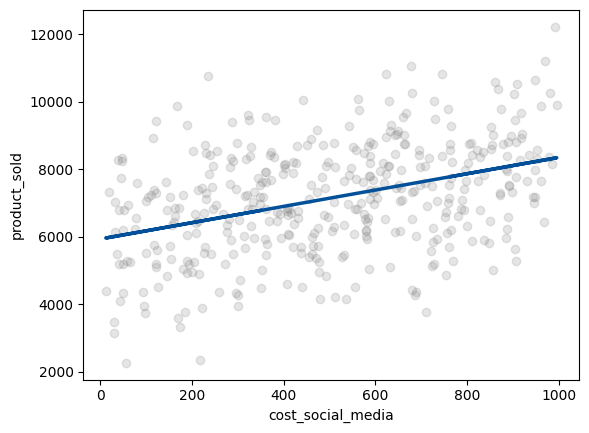

In [8]:
import matplotlib.pyplot as plt


def model_scipy(x):
    beta_0, beta_1 = betas_scipy
    return beta_0 + beta_1 * x


fix, ax = plt.subplots()
ax.scatter(cost_social_media, product_sold, color="grey", alpha=0.2)
ax.plot(
    cost_social_media, model_scipy(cost_social_media), color="#025099", linewidth=2.5
)

ax.set_xlabel("cost_social_media")
ax.set_ylabel("product_sold")

This visualization offers a clear representation of the fitted linear relationship and provides insights into the potential impact of social media advertising costs on product sales.

## sklearn

In this section, we explore an alternative approach to linear regression using the sklearn library.

Specifically, we employ the `LinearRegression` class to fit a linear model to our advertising data, relating social media advertising costs (`cost_social_media`) to product sales (`product_sold`).
Unlike the previous section, which utilized the `scipy.optimize.minimize` function for optimization, scikit-learn provides a streamlined interface for linear regression.
We'll use the `LinearRegression` class to automatically handle the optimization process and obtain optimal coefficients for our linear model.

### Reshaping arrays

The `LinearRegression` class in sklearn expects the input features (`X`) to be a 2D array for a couple of reasons related to its design and functionality:

-   The `LinearRegression` class is designed to handle multiple features simultaneously.
    When you provide a single feature, sklearn expects it to be represented as a 2D array with one column.
    This design allows the same class to seamlessly handle cases with multiple features, where each feature corresponds to a different column in the 2D array.
-   Sklearn follows a consistent API design, and many of its algorithms, including LinearRegression, are designed to work with 2D arrays or matrices as input features.
    This design choice simplifies the use of various sklearn tools and functionalities that are built around the assumption of 2D input arrays.

The `reshape(-1, 1)` operation is used to convert a 1D array into a 2D array with a single column.

In [9]:
cost_social_media_sklearn = cost_social_media.reshape(-1, 1)
product_sold_sklearn = product_sold.reshape(-1, 1)

print("Old shape")
print(product_sold.shape)
print(product_sold[:10])

print("\nNew shape")
print(product_sold_sklearn.shape)
print(product_sold_sklearn[:10])

Old shape
(400,)
[7164. 5055. 6154. 5480. 9669. 7627. 5177. 3726. 9801. 8652.]

New shape
(400, 1)
[[7164.]
 [5055.]
 [6154.]
 [5480.]
 [9669.]
 [7627.]
 [5177.]
 [3726.]
 [9801.]
 [8652.]]


### Running

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression()

model.fit(X=cost_social_media_sklearn, y=product_sold_sklearn)
betas_sklearn = [model.intercept_[0], model.coef_[0][0]]

print(f"beta_0 = {betas_sklearn[0]:.3f}")
print(f"beta_1 =    {betas_sklearn[1]:.3f}")

beta_0 = 5932.473
beta_1 =    2.418


### Analysis

TODO:

In [12]:
mse_sklearn = mse(betas_sklearn, cost_social_media, product_sold)
print(mse_sklearn)

2280263.4052002407


In [13]:
print(mse_sklearn - mse_scipy)

-5.9050507843494415e-06


Text(0, 0.5, 'product_sold')

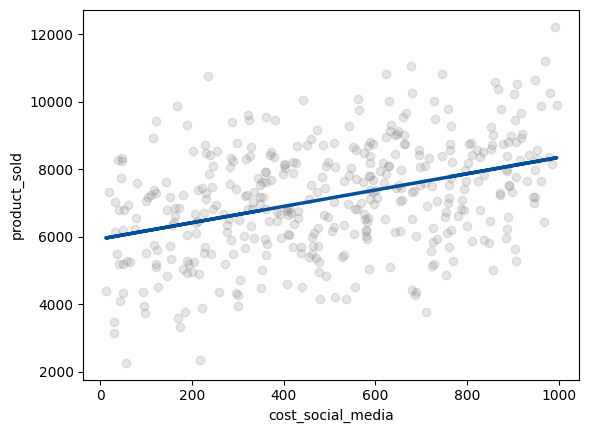

In [14]:
def model_sklearn(x, beta_0, beta_1):
    return beta_0 + beta_1 * x


fix, ax = plt.subplots()
ax.scatter(cost_social_media, product_sold, color="grey", alpha=0.2)
ax.plot(
    cost_social_media,
    model_sklearn(cost_social_media, betas_sklearn[0], betas_sklearn[1]),
    color="#025099",
    linewidth=2.5,
)

ax.set_xlabel("cost_social_media")
ax.set_ylabel("product_sold")

We can also visualize how the loss function changes with respect to the intercept and slope.
We create a range of parameters, compute the loss function, and then plot [contours](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.contourf.html#matplotlib.axes.Axes.contourf). 

In [15]:
from sklearn.metrics import mean_squared_error

model = LinearRegression()

X = cost_social_media_sklearn
y = product_sold_sklearn

model.fit(X=X, y=y)

beta_0_values = np.linspace(model.intercept_[0] * 0.5, model.intercept_[0] * 1.5, 300)
beta_1_values = np.linspace(model.coef_[0][0] * 0.5, model.coef_[0][0] * 1.5, 300)

# Initialize arrays to store results
mse_values = np.zeros((len(beta_0_values), len(beta_1_values)))

# Loop through each combination of beta_0 and beta_1
for i, beta_0 in enumerate(beta_0_values):
    for j, beta_1 in enumerate(beta_1_values):
        # Fit the model
        model.intercept_ = np.array([beta_0])  # Set beta_0
        model.coef_ = np.array([[beta_1]])  # Set beta_1
        predictions = model.predict(X)

        # Calculate mean squared error
        mse_values[i, j] = mean_squared_error(y, predictions)

rmse_values = np.sqrt(mse_values)

beta_0_values, beta_1_values = np.meshgrid(beta_0_values, beta_1_values)

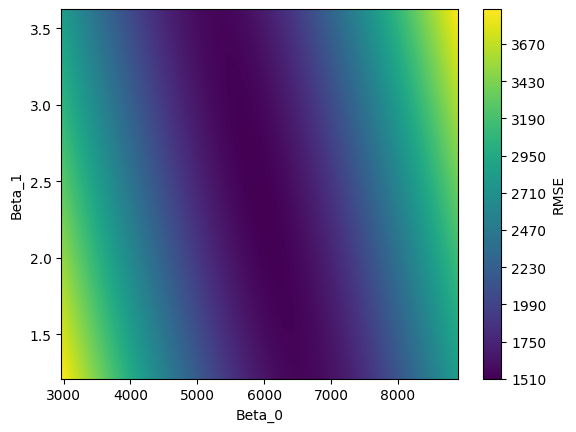

In [16]:
# Create filled contour plot
plt.contourf(beta_0_values, beta_1_values, rmse_values.T, levels=500, cmap="viridis")
plt.colorbar(label="RMSE")

plt.xlabel("Beta_0")
plt.ylabel("Beta_1")
plt.show()

## Acknowledgements

Much of this material has been adapted from [An Introduction to Statistical Learning](https://www.statlearning.com/) to be more digestible for undergraduates starting in Biology.